Valeurs manquantes par colonne :
vehicle_id       0
timestamp        0
speed            0
route_id         0
trip_id          0
latitude         0
longitude        0
trip_headsign    0
dtype: int64
Nombre de doublons : 0


C:\Users\yidir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 0.0174 - val_loss: 0.0078
Epoch 2/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 3/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 4/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 5/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 6/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 7/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 8/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 0.0059 - val_loss: 0.0058
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


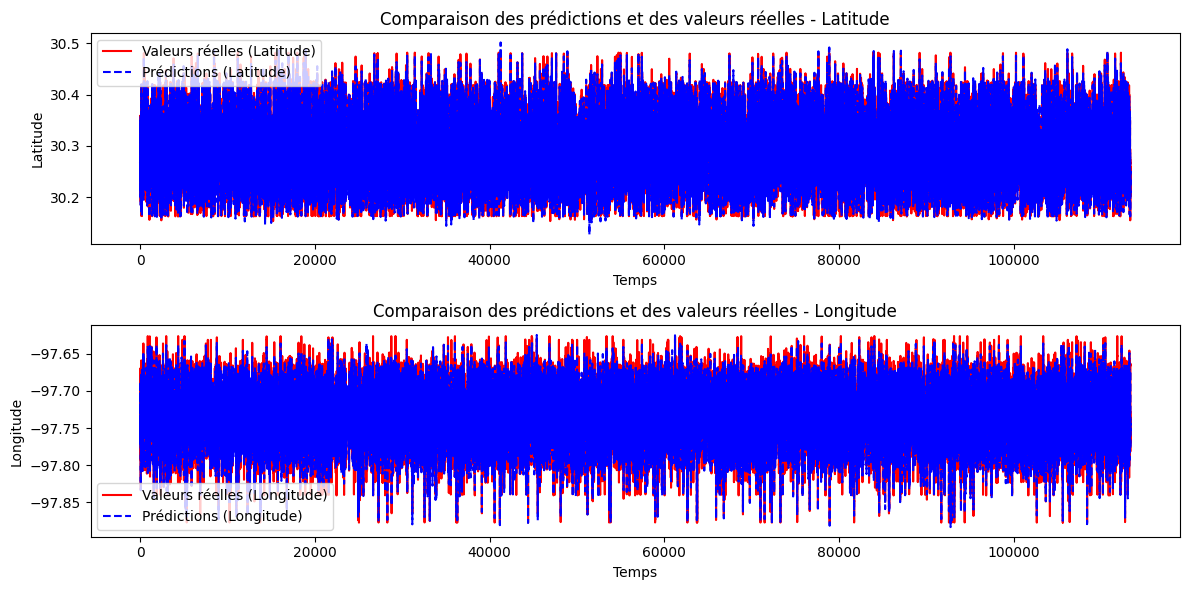

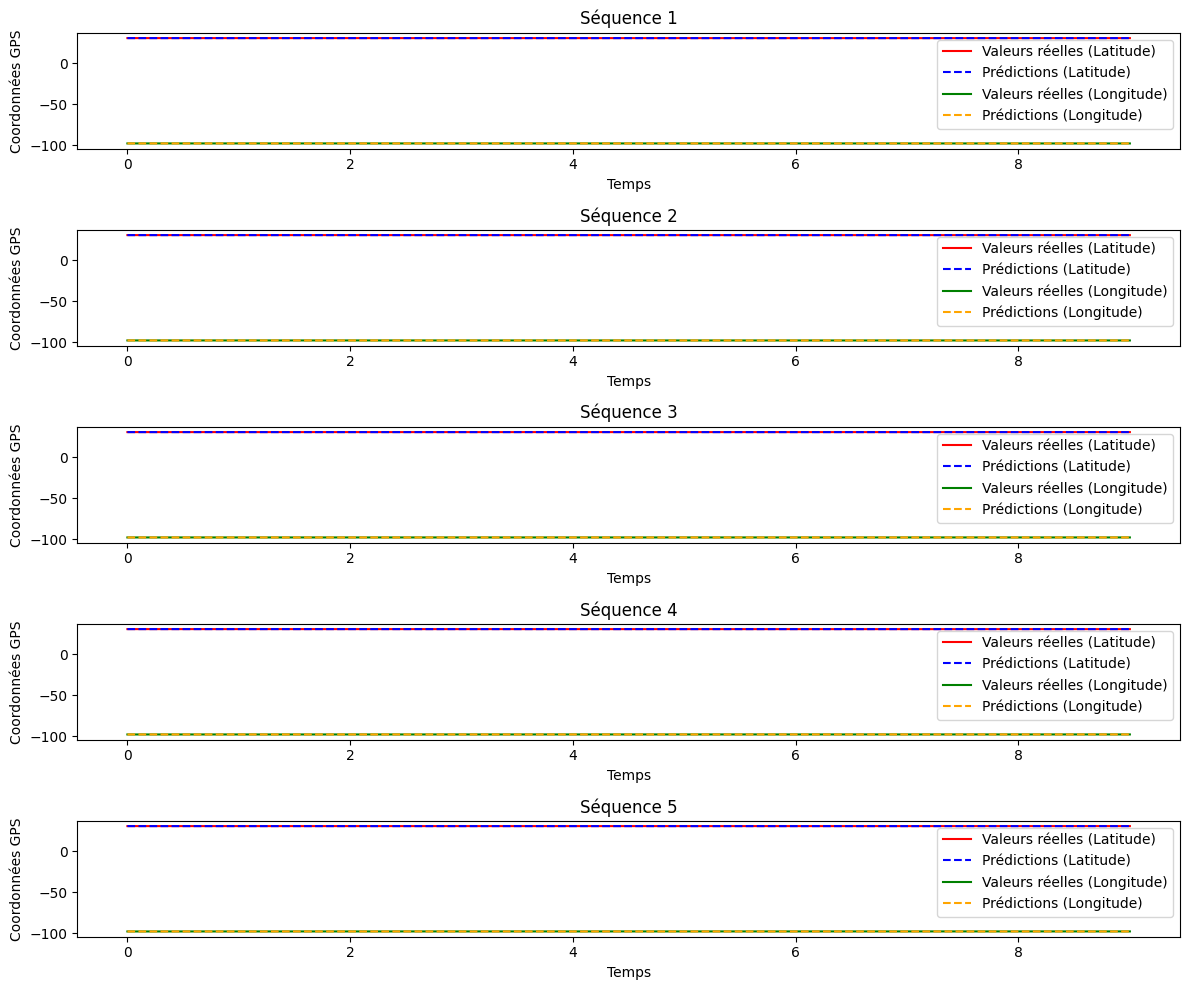

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 1. Chargement des données
file_path = 'vehicles1.csv'
data = pd.read_csv(file_path)

# 2. Prétraitement des données
data['timestamp'] = pd.to_datetime(data['timestamp'])  # Conversion en datetime
data = data.sort_values(by=['vehicle_id', 'timestamp'])  # Tri par véhicule et temps

# Vérification des valeurs manquantes et des doublons
print("Valeurs manquantes par colonne :")
print(data.isnull().sum())
print("Nombre de doublons :", data.duplicated().sum())

# Sélection des colonnes pertinentes
data = data[['vehicle_id', 'timestamp', 'speed', 'latitude', 'longitude']]

# Normalisation des données
scaler = MinMaxScaler()
data[['speed', 'latitude', 'longitude']] = scaler.fit_transform(data[['speed', 'latitude', 'longitude']])

# 4. Préparation des séquences pour le modèle
seq_length = 30  # Longueur de la séquence d'entrée
pred_length = 10  # Longueur de la séquence de sortie

X, y = [], []
vehicle_ids = data['vehicle_id'].unique()

for vehicle_id in vehicle_ids:
    vehicle_data = data[data['vehicle_id'] == vehicle_id]
    vehicle_data = vehicle_data[['speed', 'latitude', 'longitude']].values
    
    for i in range(len(vehicle_data) - seq_length - pred_length):
        X.append(vehicle_data[i:i+seq_length])  # Séquence d'entrée
        y.append(vehicle_data[i+seq_length:i+seq_length+pred_length])  # Séquence de sortie

X = np.array(X)
y = np.array(y)

# 5. Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Construction du modèle encodeur-décodeur bidirectionnel
input_shape = (seq_length, X_train.shape[2])  # Forme d'entrée : (séquence, caractéristiques)
output_shape = (pred_length, y_train.shape[2])  # Forme de sortie : (prédiction, caractéristiques)

# Encodeur
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=False, input_shape=input_shape)))  # Couche LSTM bidirectionnelle
model.add(RepeatVector(output_shape[0]))  # Répéter le vecteur pour le décodeur

# Décodeur
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Couche LSTM bidirectionnelle
model.add(TimeDistributed(Dense(output_shape[1])))  # Couche dense pour chaque pas de temps

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 7. Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# 8. Faire des prédictions sur les données de test
predictions = model.predict(X_test)  # ⚠️ Correction ici : ajout de cette ligne

# 9. Reshape pour inverser la normalisation
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
predictions_reshaped = predictions.reshape(-1, predictions.shape[2])

# 10. Inverser la normalisation des données
y_test_original = scaler.inverse_transform(y_test_reshaped)
predictions_original = scaler.inverse_transform(predictions_reshaped)

# 11. Tracer les prédictions vs les valeurs réelles pour Latitude et Longitude
plt.figure(figsize=(12, 6))

labels = ['Latitude', 'Longitude']
for i, index in enumerate([1, 2]):  # Indices 1 et 2 pour ignorer la vitesse
    plt.subplot(2, 1, i + 1)
    plt.plot(y_test_original[:, index], label=f'Valeurs réelles ({labels[i]})', color='red')
    plt.plot(predictions_original[:, index], label=f'Prédictions ({labels[i]})', linestyle='dashed', color='blue')
    plt.title(f'Comparaison des prédictions et des valeurs réelles - {labels[i]}')
    plt.xlabel('Temps')
    plt.ylabel(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

# 12. Sauvegarde du modèle entraîné
model.save('traffic_congestion_prediction_model.h5')





# 13. Affichage de plusieurs séquences
num_sequences_to_plot = 5  # Nombre de séquences à afficher

plt.figure(figsize=(12, 10))
for seq_idx in range(num_sequences_to_plot):
    plt.subplot(num_sequences_to_plot, 1, seq_idx + 1)
    
    start_idx = seq_idx * pred_length  # Index de départ dans les données
    end_idx = start_idx + pred_length  # Index de fin
    
    if end_idx > len(y_test_original):  # Vérifier qu'on ne dépasse pas la taille
        break
    
    plt.plot(y_test_original[start_idx:end_idx, 1], label='Valeurs réelles (Latitude)', color='red')
    plt.plot(predictions_original[start_idx:end_idx, 1], label='Prédictions (Latitude)', linestyle='dashed', color='blue')
    
    plt.plot(y_test_original[start_idx:end_idx, 2], label='Valeurs réelles (Longitude)', color='green')
    plt.plot(predictions_original[start_idx:end_idx, 2], label='Prédictions (Longitude)', linestyle='dashed', color='orange')

    plt.title(f'Séquence {seq_idx + 1}')
    plt.xlabel('Temps')
    plt.ylabel('Coordonnées GPS')
    plt.legend()

plt.tight_layout()
plt.show()

